In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset, scale_IR
import torch.optim as optim
from model import *
from torch.utils.data import Dataset, DataLoader


In [2]:
class CustomDataset(Dataset):
    def __init__(self, distance_dataset, IR_dataset, ground_truth, filename_dataset):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth
        self.filename_dataset = filename_dataset

    def __len__(self):
        return self.IR_dataset.shape[0]

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot, self.filename_dataset[idx]


In [3]:
trainset, testset = make_dataset()

# 创建数据集和数据加载器
train_dataset = CustomDataset(*trainset)
test_dataset = CustomDataset(*testset)

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)


distance length is 430
IR length is 430
gt length is 430
Distance train dataset: torch.Size([10734, 14, 1])
IR train dataset: torch.Size([10734, 9, 64])
gt train dataset: 10734
test dataset has file amount:  torch.Size([85, 14, 1])


In [4]:
labels = trainset[2]
# 计算每个类别出现的次数
num_samples = len(labels)
num_classes = max(labels) + 1  # 假设类别标签从0开始且连续
class_counts = [labels.count(i) for i in range(num_classes)]

# 计算每个类别的权重，使用类别频率的倒数
weights = [num_samples / class_counts[i] if class_counts[i] > 0 else 0 for i in range(num_classes)]

# 转换为Tensor
weights_tensor = torch.tensor(weights).to(mydevice)
print(weights_tensor)

tensor([9.9389, 3.0017, 6.8282, 4.0157, 5.8560], device='cuda:0')


In [5]:

# 实例化网络
net = MyMLP().to(mydevice)
# net = MyCNN().to(mydevice)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [6]:
loss_history = []
# 训练循环示例
for epoch in range(30):
    running_loss = 0.0
    for i, (IR_data, distance_data, labels, _) in enumerate(train_dataloader, 0):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)
        labels = labels.to(mydevice)
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        running_loss += loss.cpu().item()
        if i % 20 == 19:  # 每10个批次打印一次
            loss_mean = running_loss / 20
            loss_history.append(loss_mean)
            print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
            running_loss = 0.0


[1, 20] loss: 7.954
[1, 40] loss: 8.086
[1, 60] loss: 7.918
[1, 80] loss: 7.726
[1, 100] loss: 7.606
[1, 120] loss: 8.280
[1, 140] loss: 8.222
[1, 160] loss: 8.414
[1, 180] loss: 8.186
[1, 200] loss: 7.780
[1, 220] loss: 7.970
[1, 240] loss: 7.923
[1, 260] loss: 8.616
[1, 280] loss: 7.697
[1, 300] loss: 7.709
[1, 320] loss: 8.136
[1, 340] loss: 7.409
[1, 360] loss: 8.223
[1, 380] loss: 7.647
[1, 400] loss: 8.147
[1, 420] loss: 8.000
[1, 440] loss: 7.575
[1, 460] loss: 8.481
[1, 480] loss: 7.613
[1, 500] loss: 8.141
[1, 520] loss: 7.953
[1, 540] loss: 7.696
[1, 560] loss: 8.419
[1, 580] loss: 8.024
[1, 600] loss: 7.571
[1, 620] loss: 7.754
[1, 640] loss: 7.561
[1, 660] loss: 7.788
[1, 680] loss: 7.851
[1, 700] loss: 8.418
[1, 720] loss: 7.740
[1, 740] loss: 8.162
[1, 760] loss: 7.460
[1, 780] loss: 7.113
[1, 800] loss: 7.240
[1, 820] loss: 8.276
[1, 840] loss: 8.316
[1, 860] loss: 7.392
[1, 880] loss: 7.251
[1, 900] loss: 7.564
[1, 920] loss: 8.056
[1, 940] loss: 7.774
[1, 960] loss: 7.

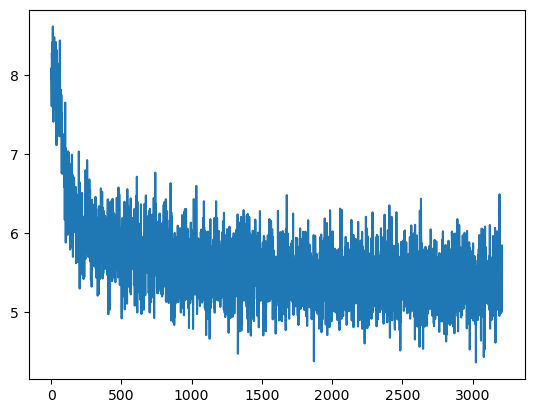

In [7]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
filenames = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())
        filenames += filename

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}\n")

# 计算每个类别的精确度和召回率
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# 打印结果
print("labels are ", ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit'])
print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}\n")

from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

print("混淆矩阵:")
print(cm)

Accuracy: 0.9059
Precision: 0.9082
Recall: 0.9059

labels are  ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit']
Precision per class: [1.         0.95       0.94444444 0.85185185 0.77777778]
Recall per class: [1.         0.86363636 0.94444444 0.92       0.77777778]

混淆矩阵:
[[11  0  0  0  0]
 [ 0 19  0  2  1]
 [ 0  0 17  1  0]
 [ 0  0  1 23  1]
 [ 0  1  0  1  7]]


In [9]:
# 找出被错误分类的样本
misclassified_samples = [filenames[i] for i in range(len(filenames)) if true_labels[i] != predicted_labels[i]]
print("被错误分类的样本:", misclassified_samples)

被错误分类的样本: ['../data_v2/high-positon-stand2sit/苗新凯_高位_站姿到坐姿_1712728668', '../data_v2/high-position-sit/刘朝宇_高位_坐姿_1712732097', '../data_v2/high-position-sit/1712645282', '../data_v2/high-position-sit/1712645977', '../data_v2/high-position-stand/1712650084', '../data_v2/high-positon-stand2sit/1712652307', '../data_v2/high-position-stand/1712646048', '../data_v2/high-position-sit2stand/李兵丰_高位_坐姿到站姿_1712731263']


In [10]:
import shutil
import os
from datetime import datetime
from pathlib import Path

# 创建目标文件夹
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
target_folder = os.path.join("wrongs", timestamp)
os.makedirs(target_folder, exist_ok=True)

# 复制被错误分类的样本到目标文件夹
for filename in misclassified_samples:
    # 假设原始文件位于当前文件夹中
    # folder, sample_id = filename.split('_')
    source_path = f'{filename}.mp4' # Path('..') / 'data_v2' / folder / f'{sample_id}.mp4'
    # target_path = os.path.join(target_folder, os.path.basename(filename))
    shutil.copy(source_path, target_folder)

print(f"被错误分类的样本已复制到 {target_folder}")


被错误分类的样本已复制到 wrongs/20240410-172453


In [11]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

Total parameters: 3165


In [12]:
torch.save(net.state_dict(), 'checkpoints_v2/high/AllData_v2_balanced_0d90.pth')